### PyKGML: Quick Start Example
This notebook demonstrates the use of [**PyKGML**](https://github.com/AI4Agriculture/PyKGML_development), a Python libaray for efficient knowledge-guided machine learning (KGML) development. 

In this example, we will demonstrate how develop a KGML model to predict CO<sub>2</sub> fluxes. The modeling steps include:   
- Pretraining a pure machine learning model using synthetic data.  
- Designing a knowledge-guided model architecture.  
- Customizing a loss function.  
- Fine-tuning the pretrained model using field observations.  


### Step 1: import libraries and classes

This step introduces libraries and classes used to build a basic model in this tutorial. PyKGML's machine learning framework is built on [PyTorch](https://pytorch.org/). We will discuss a few key PyTorch functions here, and it's recommended to explore other common functions as well. In addition to PyTorch, PyKGML includes two container files, [time_series_models.py](time_series_models.py) and [kgml_lib.py](kgml_lib.py), to store customized functions and classes used throughout the framework.

1. **PyTorch libraries**  
- **`torch`**: The main PyTorch library for deep learning. Functions such as `torch.tensor()`, `torch.load()` are commonly used for data processing and model development.

- **`torch.nn`**: the torch neural network mudule. It provides all kinds of functions and layers for constructing a machine learning model, such as recurrent algorithm layers (e.g. `nn.RNN`, `nn.GRU`, `nn.LSTM`), loss functions (`nn.MSELoss`, `nn.L1Loss`, `nn.CrossEntropyLoss`), and activation functions (e.g. `nn.ReLU`, `nn.GELU`). 

- **`dataLoader`**: an efficient utility that handle data batching, shuffling, and parallel loading. We'll use it to organize and feed data into the model during training.

2. **PyKGML containers**  
- [**time_series_models.py**](time_series_models.py): stores pre-defined neural network algorithms and implementation tools.  

    - Models included in the current gallery are focusing on time sequence prediction:  
        - **`GRUSeq2Seq`**: a Gated Recurrent Unit (GRU) model is suitable for sequencial inputs and sequential outputs. Efficient and lightweight; ideal for moderate-length sequences where long-term dependencies are limited.

        - **`LSTMSeq2Seq`**: a Long Short-Term Memory (LSTM) model. It captures long-range temporal dependencies; suitable for time series or text data with complex context.

        - **`1dCNN`**: 1D convolutional neural networks (CNN) model. Fast and parallelizable; excels at extracting local temporal or spatial features from fixed-length sequences.

        - **`Attention`**: a self-attention model. It learns global dependencies directly; ideal for tasks requiring contextual understanding across entire sequences. 

        - **`TimeSeriesTransformer`**: a transformer encoder model. It combines scalability and long-range modeling; best for multivariate or irregular time series data.

        - **`GRUSeq2SeqWithAttention`**: a GRU + self-attention hybrid model for sequential inputs and outputs with different temporal resolutions. It balances efficiency and global context; effective when input and output sequences differ in length or sampling rate.

        - **`N2OGRU_KGML`**: This is a simplified version of KGMLag-N2O model structure from [Liu et al., 2022](https://doi.org/10.5194/gmd-15-2839-2022)
        - **`RecoGRU_KGML`**: This is the simplified version of KGMLag-CO2 model structure from [Liu et al., 2024](https://www.nature.com/articles/s41467-023-43860-5)  

    - **`SequenceDataset`**: this is a class that help prepares the data as samples with a specified sequence length and stores them along with the corresponding labels.  
    It works with PyTorch’s **`DataLoader`** to create an iterable to enable easy access to the samples.

- [**kgml_lib.py**](kgml_lib.py): This is a container where utility functions are defined and stored:
    - `Z_norm`, `Z_norm_with_scaler`: normalization without or with provided scalers (usually mean and standard deviation). 

    - `Z_norm_reverse`: reverse normalization. 

    - `LossFunctionCompiler`: a compiler for loss function design.

    - `ModelStructureCompiler`: a compiler for model structure design.
    
    - `plot_features`: a function for plotting feature histograms.

In [ ]:
# Install packages for local environment, not necessary for Colab
%pip install -r requirements.txt

In [ ]:
# Import Python libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import classes/functions from the PyKGML
from time_series_models import GRUSeq2SeqWithAttention, SequenceDataset
from dataset import plot_features
import kgml_lib

### Step 2: data preparation  

In this step, we will learn about the example datasets for pretraining and fine-tuning, understand the dimension, features, training and testing split, and methods to load and visualize data.

1. **Dataset**  

    Two example datasets were used in this toturial:  
    - **co2_pretrain_data.sav**: synthetic data for model pretraining.  
    - **co2_finetune_data.sav**: field observation data for fine-tuning.  
        
    The dataset was a serilized disctionary that looks like this:  
    ```python   
        co2_pretrain_data = {'X_train': X_train,  
                            'X_test': X_test,  
                            'Y_train': Y_train,  
                            'Y_test': Y_test,  
                            'x_scaler': x_scaler, 
                            'y_scaler': y_scaler,  
                            'input_features': input_features,  
                            'output_features': output_features}   
    ```    
    Values in the dictionary are tensors and their dimensions are:  
    - X_train: input data for training, [samples, sequences, features].  
    - X_test: input data for testing, [samples, sequences, features].  
    - Y_train: output data for training, [samples, sequences, features].  
    - Y_test: output data for testing, [samples, sequences, features].  
    - x_scaler: the scaler used to normalize the input data, [features, [mean, std]].  
    - y_scaler: the scaler used to normalize the output data, [features, [mean, std]].  
    - input_features: a list of input feature names.  
    - output_features: a list of output feature names.  

<br>

2. **Loading method**   

    `torch.load()` is used to load the example data file: 
    ```python
        pretrain_data = torch.load('co2_pretrain_data.sav', weights_only=False)  
    ```
    weights_only is parameter with True indicating the loaded data is restricted to tensor weights.

<br>

3. **Descriptions of the dataset**
    - **co2_pretrain_data**:  
        - 100 samples (100 sites)
        - Each sample is a daily sequence over 18 years (6570) 
        - 19 input_features and 3 output_features 
        - Data split: 80 samples in the training set and 20 samples in the testing set.

        Input features (19):
        - Meterological (7): solar radiation (RADN), max air T (TMAX_AIR), (max-min) air T (TDIF_AIR), max air humidity (HMAX_AIR), (max-min) air humidity (HDIF_AIR), wind speed (WIND), precipitation (PRECN).
        - Soil properties (9): bulk density (TBKDS), sand content (TSAND), silt content (TSILT), field capacity (TFC), wilting point (TWP), saturate hydraulic conductivity (TKSat), soil organic carbon concetration (TSOC), pH (TPH), cation exchange capacity (TCEC)
        - Other (3): year (Year), crop type (Crop_Type), gross primary productivity (GPP)

       Output features (3):
        - Autotrophic respiration (Ra), heterotrophic respiration (Rh), net ecosystem exchange (NEE). 
          
    - **co2_finetune_data**:  
        - One sample (11 sites were concatnated into one sequence due to varied sequence lengths)
        - A Daily sequence of total 124 site-years (45260 in length)
        - 19 input_features and 2 output_features  
        - Data split: the last 2 years from each site were combined as the testing set and the rest were set as the training set.

        Input features (19):
        - The same as co2_pretrain_data.  
       
        Output features (2):
        - Ecosystem respiration (Reco, Reco = Ra + Rh), net ecosystem exchange (NEE). 
    
    Features are the same in the two datasets, except that co2_finetune_data does not have Ra and Rh directly but have Reco, which is the combination of Ra and Rh. Reco and NEE of co2_finetune_data in Y_train and Y_test are not standardized so co2_finetune_data has no y_scaler.

<br>

4. **Visualizing input and output features**  

    The function plot_features() can be used to visualize the distributions of inputs and outputs. It has the following four parameters:
    ```python
    plot_features(data, feature_number, feature_name, sub_title)
    ```

In [ ]:
# Load dataset
data_path = '/Users/yufengyang/Documents/GitHub/data/PyKGML/' # change this path to where you downloaded the data to 
output_path = data_path + 'test_results/CO2/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

pretrain_file = data_path + 'co2_pretrain_data.sav'
pretrain_data = torch.load(pretrain_file, weights_only=False)
finetune_file = data_path + 'co2_finetune_data.sav'
finetune_data = torch.load(finetune_file, weights_only=False)
print(pretrain_data.keys())
print(finetune_data.keys())

dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'x_scaler', 'y_scaler', 'input_features', 'output_features'])
dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'x_scaler', 'input_features', 'output_features'])


In [ ]:
# Assign training and testing data. 
X_train, X_test, Y_train, Y_test = pretrain_data['X_train'], pretrain_data['X_test'], pretrain_data['Y_train'], pretrain_data['Y_test']
# y_scaler contains the means and stds. To reverse Y data to the original, use kgml.lib.Z_norm_reverse
x_scaler = pretrain_data['x_scaler']
y_scaler = pretrain_data['y_scaler']
input_features = pretrain_data['input_features']
output_features = pretrain_data['output_features']

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print(x_scaler.shape, y_scaler.shape)
print(input_features)
print(output_features)

torch.Size([20, 6570, 19]) torch.Size([20, 6570, 3]) torch.Size([80, 6570, 19]) torch.Size([80, 6570, 3])
(19, 2) (3, 2)
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC'] ['Ra', 'Rh', 'NEE']


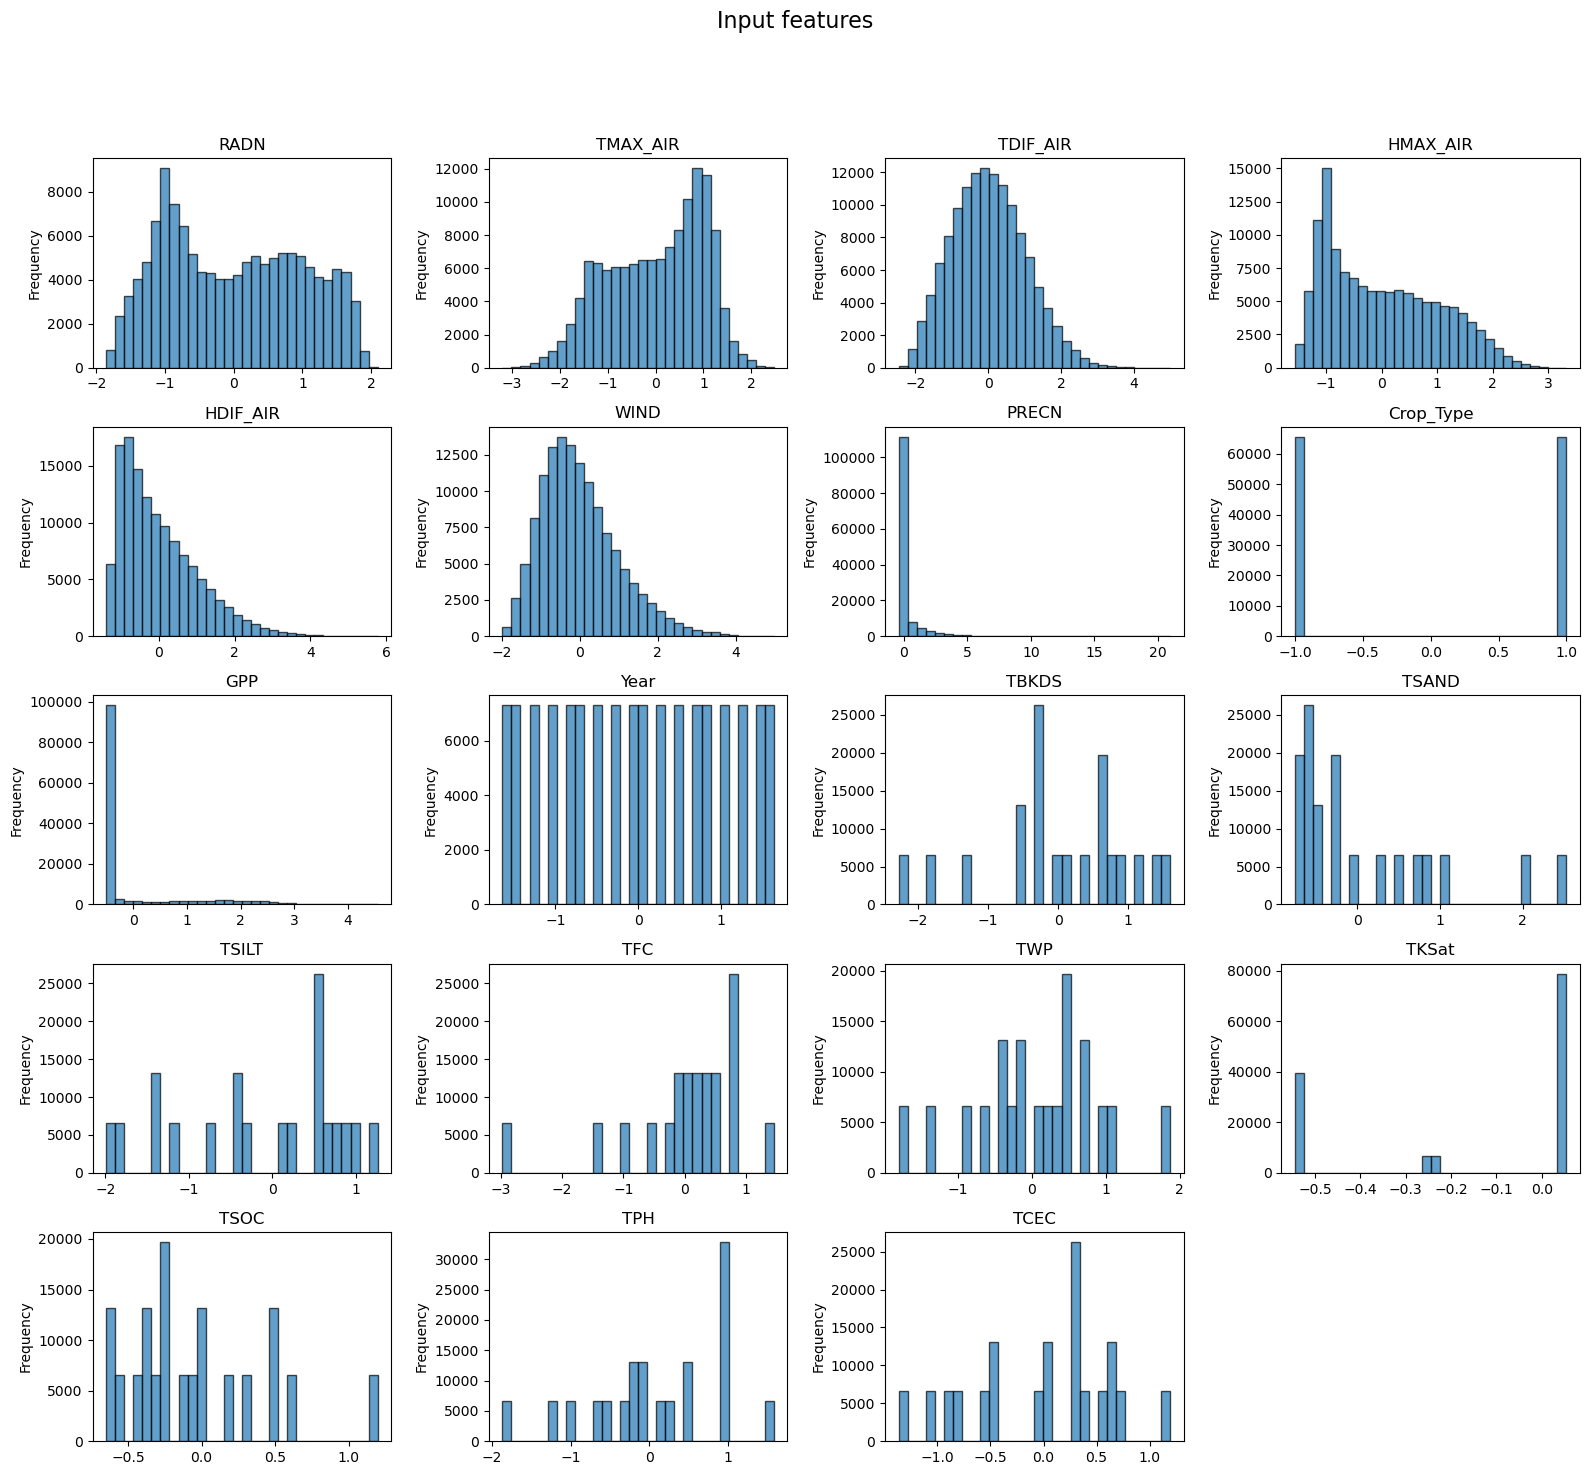

In [ ]:
# View histograms of input features
feature_len = len(input_features)
features = input_features
values = X_train.reshape(-1, feature_len)
sub_title = "Input features"
plot_features(data=values, feature_number=feature_len, feature_name=features, sub_title=sub_title)

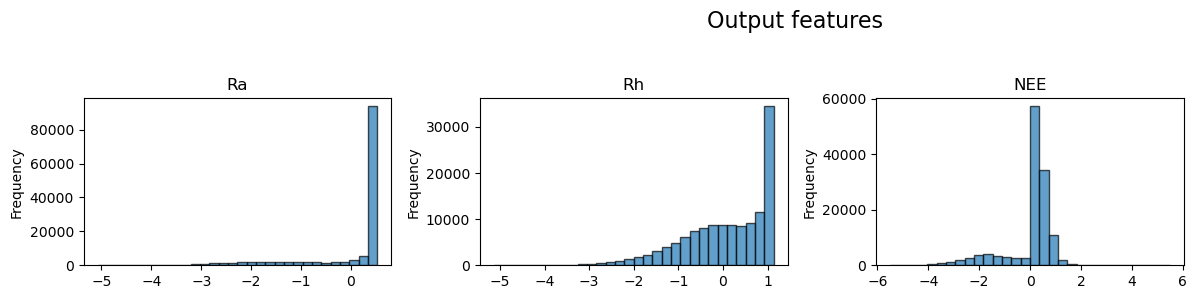

In [48]:
# View histogram of output features
feature_len = len(output_features)
features = output_features
values = Y_train.reshape(-1, feature_len)
sub_title = "Output features"
plot_features(values, feature_len, features, sub_title)

### Step 3: model pretraining  

In this step, we will demonstrate how to use the synthetic data to pretrain a basic ML model. There are two main implementation steps: training and testing. The purpose of spliting data into training and testing sets is to prevent data leakage and ensure model generalize well to unseen data and scenarios.

1. **Model parameters**:
    There are some shared parameters among models: `input_dim` (input dimension), `hidden_dim` (hidden layer dimension), `num_layers` (number of hidden layers), `output_dim` (output dimension). `dropout` parameter is a regularization technique used to prevent overfitting. It randomly “drops out” (sets to zero) a fraction (0-1) of neurons in a layer on each forward pass.

    - `GRUSeq2Seq (input_dim, hidden_dim, num_layers, output_dim)` 
    
    - `LSTMSeq2Seq (input_dim, hidden_dim, num_layers, output_dim)`   

    - `1dCNN (input_dim, hidden_dim, num_layers, output_dim, dropout)`  

    - `Attention (input_dim, hidden_dim, num_layers, output_dim)` 

    - `GRUSeq2SeqWithAttention (input_dim, hidden_dim, num_layers, output_dim, dropout)`   

    - `TimeSeriesTransformer (input_dim, hidden_dim, num_layers, output_dim, d_model, nhead, dropout)` 

      `d_model` (embedding dimension) is the size of the input and output vectors for each token in the Transformer.  
      `nhead` defines how many parallel attention heads are used in each layer. The multi-head attention mechanism splits the d_model vector into smaller subspaces, each handled by one head.

    - `N2OGRU_KGML (input_dim, hidden_dim, num_layers, output_dim1, output_dim2, dropout)`  
    
      `output_dim1` and `output_dim2` are the dimensions of intermediate outputs and the final target outputs. This is a design specified in this model that use intermediate variables to bridge the relations of input and target outputs.

    - `RecoGRU_KGML (input_dim, hidden_dim, num_layers, output_dim, dropout)` 

    To define a model, for example:
      ```python 
      GRUSeq2Seq (input_dim, hidden_dim, num_layers, output_dim)
      ```
    

<br>

2. **Data loader**:

    SequenceDataset function is used to organize and access data and provide necessary transformation. 
    
    - `SequenceDataset(inputs, outputs, sequence_length)`   
        
      `sequence_length` is a parameter that decides the length of sequences. You have probably noticed that the training and testing data comprise long sequences (dimension=6570) with some repteated patterns, i.e. seasonality. So reshaping sequences by year is a good strategy as it imporve stability, facilitate parallelization (faster training), and enable better generalization across time.

      For example, an inputs of size [1 sample, 750 days, 5 features] can be converted to the size of [2, 365, 5] given sequence_length = 365. 
    
    DataLoader is a function that takes a dataset and loads it in mini-batches, so it can feed data efficiently during Training.
    - `DataLoader(train_dataset, batch_size, shuffle=True)` 
    
      Refer to the official [documentation](https://docs.pytorch.org/docs/stable/data.html) for the full list of parameters.
    
    To get data ready in the dataloader:
      ```ptyhon
      train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
      test_dataset = SequenceDataset(X_test, Y_test, sequence_length)
      model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)
      ```

<br>

3. **Training**
    Model training can be implemented in one line:
    ```python
    model.train_model(loss_func, LR, step_size, gamma, maxepoch, checkpoint_path)
    ```

    `loss_func` is the loss_function. `checkpoint_path` is the path to store the trained model parameters. Ohters are required hyperparameters.  

      - `LR` (learning rate): controls how much the model weights are updated during each optimization step.  
      - `step_size` (step size): defines how many epochs pass before the learning rate is reduced in a scheduler.  
      - `gamma`: the factor by which the learning rate is multiplied after each step (e.g., 0.9 means a 10% decay).  
      - `maxepoch` (max epoches): the maximum number of complete passes (epochs) through the entire training dataset.

<br>

4. **Testing and visualization**
    Model testing is done with the testing dataset using `model.test()`. There are 3 visualization functions so far.
    - `model.plot_training_curves()`  
      Plot the training curve (learning curve). A learning curve shows how a model’s performance (e.g., loss or accuracy) changes over time during training and validation, typically plotted against the number of epochs.

    - `model.vis_plot_prediction_result_time_series(y_scaler, output_feature_name, sample)`  
      Visualize the temporal relationship of predictions and truth values for a given sample.

    - `model.vis_scatter_prediction_result(y_scaler, output_feature_name)`  
      Visualize the relationship between model predictions and true values using a scatter plot of all data points.


In [49]:
# Set parameters for a selected model
input_dim = len(input_features)
hidden_dim = 128
num_layers = 3
output_dim = len(output_features)
dropout = 0.2

# Define a model 
model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [50]:
# Use 365 consecutive days as a sample
sequence_length = 365  

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create the dataLoaders for training and testing
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [51]:
# Set hyperparameters for model training
learning_rate = 0.001
step_size = 20
max_epoch = 50
gamma = 0.6

# Set a loss function. Here we select nn.L1Loss() from PyTorch. nn.MSELoss() is another option 
loss_function = nn.L1Loss() 
# Set the path to save model weights
checkpoint_path = output_path + 'pretrained_GRU.pth'

# train the model
model.train_model(loss_func=loss_function, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=checkpoint_path)

Epoch 1/50 | LR: 0.001000, Train Loss: 0.6001, Test Loss: 0.5216
Epoch 2/50 | LR: 0.001000, Train Loss: 0.4357, Test Loss: 0.4270
Epoch 3/50 | LR: 0.001000, Train Loss: 0.3526, Test Loss: 0.3265
Epoch 4/50 | LR: 0.001000, Train Loss: 0.2767, Test Loss: 0.2789
Epoch 5/50 | LR: 0.001000, Train Loss: 0.2473, Test Loss: 0.2601
Epoch 6/50 | LR: 0.001000, Train Loss: 0.2282, Test Loss: 0.2361
Epoch 7/50 | LR: 0.001000, Train Loss: 0.2146, Test Loss: 0.2216
Epoch 8/50 | LR: 0.001000, Train Loss: 0.2027, Test Loss: 0.2145
Epoch 9/50 | LR: 0.001000, Train Loss: 0.1922, Test Loss: 0.2085
Epoch 10/50 | LR: 0.001000, Train Loss: 0.1837, Test Loss: 0.1979
Epoch 11/50 | LR: 0.001000, Train Loss: 0.1758, Test Loss: 0.1894
Epoch 12/50 | LR: 0.001000, Train Loss: 0.1692, Test Loss: 0.1827
Epoch 13/50 | LR: 0.001000, Train Loss: 0.1636, Test Loss: 0.1831
Epoch 14/50 | LR: 0.001000, Train Loss: 0.1596, Test Loss: 0.1786
Epoch 15/50 | LR: 0.001000, Train Loss: 0.1568, Test Loss: 0.1778
Epoch 16/50 | LR: 0

In [52]:
# model testing using test_dataset
model.test()

Test Loss: 0.1628


### Visualization
Functions for visualizing the model performance incude:  
- **plot_training_curves()**: plot the loss curves of training and testing. 

- **vis_plot_prediction_result_time_series(y_scaler, output_feature_name)**: visualize the predicted sequence vs. the true values at a specific sample location.  

- **vis_scatter_prediction_result(y_scaler, output_feature_name)**: visualize the predicted values vs. true values in scatters.


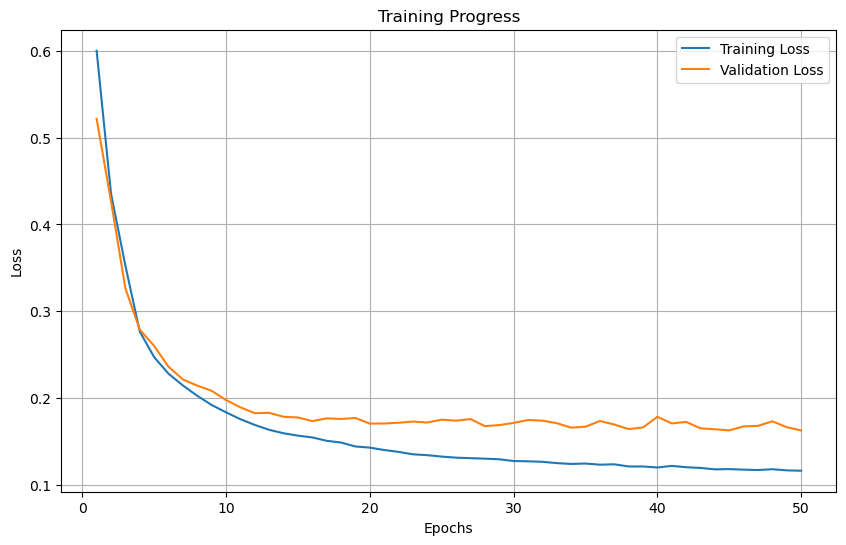

In [ ]:
# Plot the learning curves
model.plot_training_curves()

# A learning curve shows how a model’s performance changes over time during training and validation. 
# It can be used to:
# Diagnose underfitting or overfitting (e.g., if training improves but validation stalls or worsens).
# Monitor training progress and determine when to stop training (early stopping).
# Compare models or hyperparameters to see which settings lead to faster or more stable learning.

In [54]:
# Calculate model's coefficient of determination
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9535379969536288
Feature Rh R2 Score is: 0.8228621686831661
Feature NEE R2 Score is: 0.9517725572384061


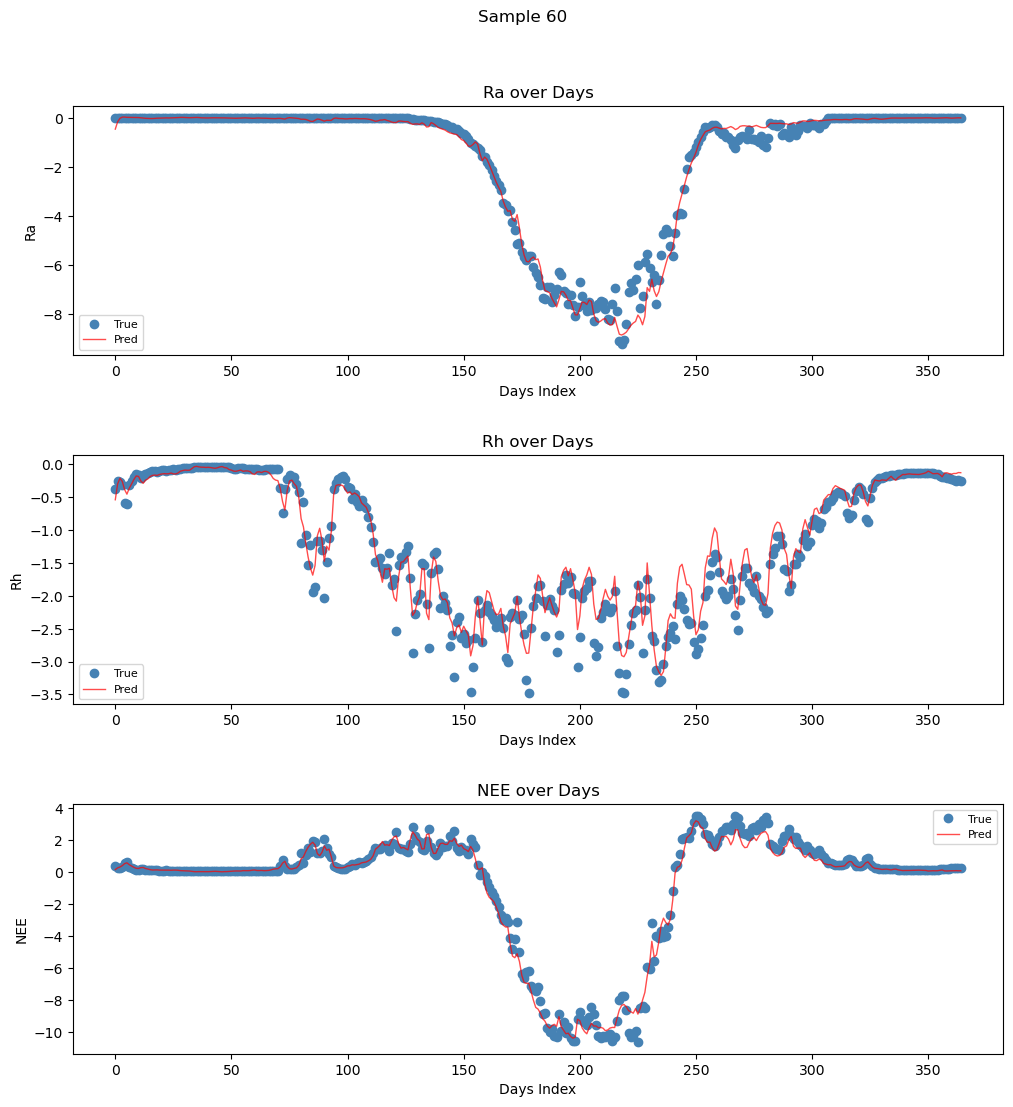

In [55]:
# Visualize the time series of model prediction and true value at a given sample
model.vis_plot_prediction_result_time_series(y_scaler, output_feature_name, sample=60)

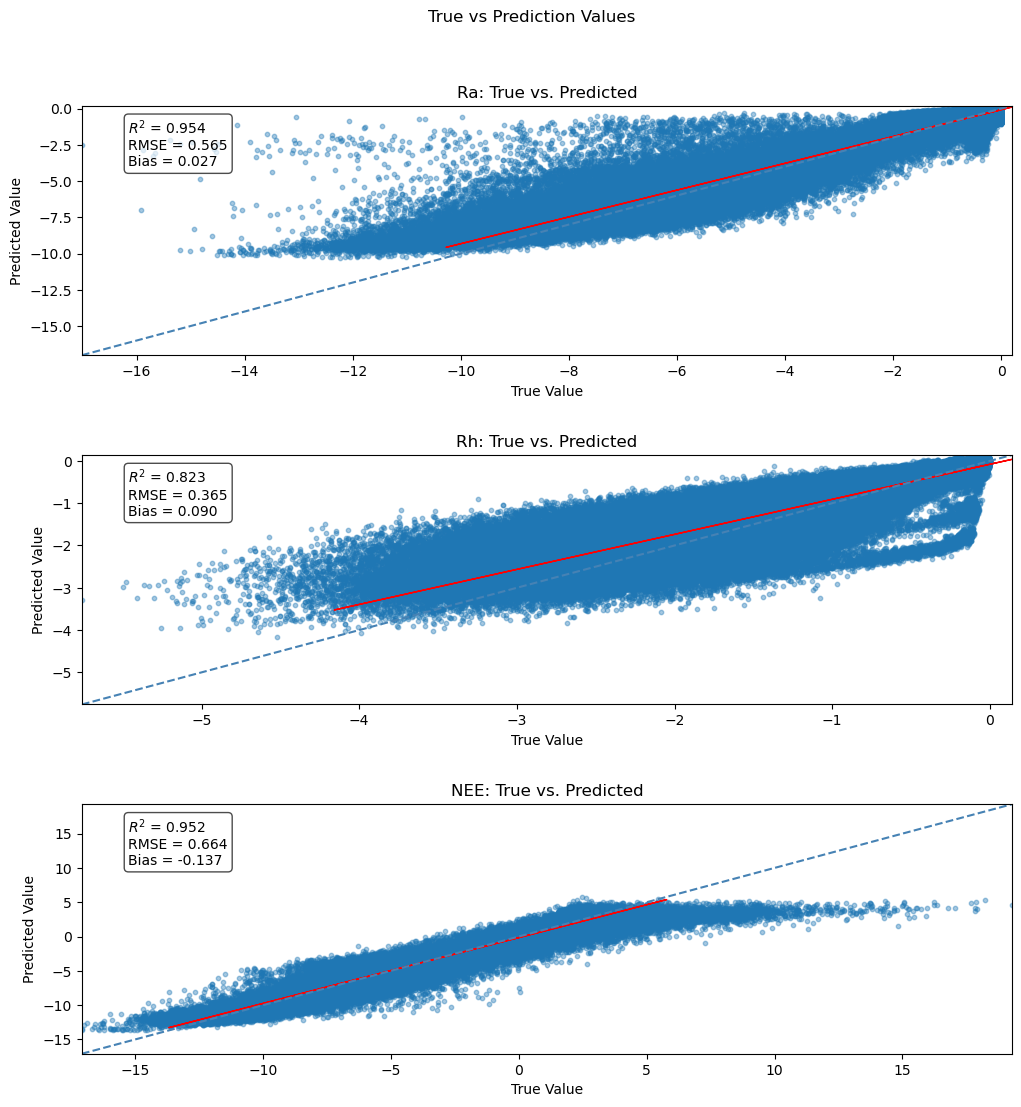

In [56]:
# Visulize the prediction vs. true value on a scatter plot
model.vis_scatter_prediction_result(y_scaler, output_feature_name)

---
### Advanced functions

The above is a simple example of using PyKGML to pretrain a model on the synthetic data.  

In the following steps, we will explore advanced functions of PyKGML, including design a model structure, customize a loss function and fine-tune a pretrained model. 

### Step 4: model structure design

In this step, we will demonstrate the use the PyKGML tool for model design, `ModelStructureCompiler`. The compiler generates a model architecture following a predefined blueprint, which users can modify to suit specific needs.

1. **Model structure**  
    As a work example, we proposed a GRU-based model structure that simplifies the KGMLag model in [Liu's 2024 paper](https://www.nature.com/articles/s41467-023-43860-5). The KGMLag model is designed to simulate ecosystem CO<sub>2</sub> fluxes with a structure that reflects the relationship among the three response variables, auotrophic respiration (Ra), heterotrophic respiration (Rh), and net ecosystem exchange (NEE).
  
    This proposed model does not nessacerily outperform the previous pretrained GRU model, but it highlights the causal relationships using a hierarchical structure. For understanding how to build a KGML model using strategies including structure design that can perform better than a pure ML baseline, please refer to the original study.


    In the diagram:
    * There are four GRU cells, Cell-1 (GRU-basic), Cell-2 (GRU-Ra), Cell-3 (GRU-Rh), and Cell-4 (GRU-NEE). Each cell has its own output (output1, output2, output3, and output4).  

    * There are three fully connected (FC) layers for converting outputs from GRU cells to the target variables: Ra, Rh, and NEE.  

    * Inside the parentheses are the input and the output of a GRU cell or FC layer. 

    * Inside the square brackets are the dimension corresponding to the input and output.  

    * The colored arrow indicates an output from a cell with the same color goes to another cell as an input.  

    <img src="./Model structure.png">


<br>

2. **configuration**  

    The compiler of structure design can be imported from kgml_lib by

    ```python
        from kgml_lib import ModelStructureCompiler
    ```

    or  
    ```python
        import kgml_lib  
        ModelStructureCompiler = kgml_lib.ModelStructureCompiler  
    ```


    A configuration script is used to describe the proposed model structure following this format:

    ```python
        archt_config = {
        # define name and parameters
        'class_name': str,
        'base_class': 'TimeSeriesModel',
        'init_params': {
                'input_dim': int,
                'hidden_dim': int,
                'num_layers': int,
                'output_dim': int,
                'dropout': float
        },
        # Define model components 
        'layers': {
                'layer1': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
                'layer2': ('lstm', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
                'dropout':   ('dropout', 'dropout'),
                'fc':        ('linear', 'hidden_dim', 'output_dim'),
                ...
        },
        # Define the forward function. 
        'forward': {
                ...
        }
        }
    ```
    The configuration script contains the following components:
    - `class_name` is the name of the designed model class and should be a string.  

    - `base_class` is fixed as `TimeSeriesModel`.  

    - `init_params` should include all parameters required for the selected model as indicated in step 3.  

    - `layers` is a dictionary. It's the workplace for declaring functions (algorithms, avtivations) needed to build the structure. The key is a user-defined name of a layer. Any functions in the torch.nn library can be used as the value. For functions in the list of [`nn.GRU`, `nn.LSTM`, `nn.Linear`, `nn.Dropout`, `nn.Attention`, `nn.ReLU`, `nn.Tanh`, `nn.functional.softmax`], the compiler can regonize them by simplified forms as in ['gru', 'lstm', 'linear', 'dropout', 'attention', 'relu', 'tanh', 'softmax'].

    - `forward` is a dictionary. It's the workplace for assemblying layers together to form the structure. The {key: value} pair represents the output name (key) and the forward layers (value). In this configuration, `x` is reserved for representing model inputs. For example:  

    ```python
        forward: {
        'output1': 'layer1(x)', 
        'output2': 'layer2(output1)'
        }
        # It indicates output1 is the output of layer1 fed with inputs X, and output2 is the output of layer2 fed with output1.
    ```

    - Some operations will come into use for the forward construction: 
      - `'&'` is used as tensor concatenation.
      - `'@'` is used as matrix multiplication.
      - `'.'` is used as dot product. 

    We will build the structure of the proposed model to demonstrate more details about the configuration.

In [57]:
# Import the help compiler for model structure design
ModelStructureCompiler = kgml_lib.ModelStructureCompiler

# Fill a configuration script to describe the proposed model structure
archt_config = {
    # define name and parameters
    'class_name': 'my_KGML',
    'base_class': 'TimeSeriesModel',
    'init_params': {
        'input_dim': 19,
        'hidden_dim': 128,
        'num_layers': 2,
        'output_dim': 3,
        'dropout': 0.2
    },
    # Define model components, where the key is a given name for a layer and the value is tuple of layer parameters. 
    # The first parameter is the layer name, which can be 'gru' for torch.nn.GRU or 'lstm' for torch.nn.LSTM.
    # The rest of the parameters in the tuple are parameters feed to the layer. 
    'layers': {
            'gru_basic': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_ra':    ('gru', 'input_dim + hidden_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_rh':    ('gru', 'input_dim + hidden_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_nee':   ('gru', 'input_dim+2', 'hidden_dim', 'num_layers', 'dropout'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
    },
    # Define the forward function. This is where layers are connected to each other with inputs and outputs.
    'forward': {
        'out_basic, hidden': 'gru_basic(x)',
        'dropped':   'dropout(out_basic)',
        'ra_in':     'x & dropped',
        'ra_out, hidden':    'gru_ra(ra_in)',
        'ra_pred':   'fc(dropout(ra_out))',
        'rh_in':     'x & dropped',
        'rh_out, hidden':    'gru_rh(rh_in)',
        'rh_pred':   'fc(dropout(rh_out))',
        'nee_in':    'x & ra_pred & rh_pred',
        'nee_out, hidden':   'gru_nee(nee_in)',
        'nee_pred':  'fc(dropout(nee_out))',
        'output':    'ra_pred & rh_pred & nee_pred'
    }
}


In [58]:
# Feed the config to the pre-defined compiler. 
archt_compiler = ModelStructureCompiler(archt_config)

# Call generate_model() on the compiler to generate a model class.
KGML = archt_compiler.generate_model()

# Call class_code on the compiler to show the generated model structure.
print("Generated class code:")
print(archt_compiler.class_code)

Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.gru_basic = nn.GRU(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_ra = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_rh = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_nee = nn.GRU(input_dim+2, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.T

In [59]:
# Define a model using the compiled architecture
myKGML1 = KGML()
# Create dataLoaders for the model
batch_size = 64
myKGML1.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
myKGML1.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Set up hyperparameters
learning_rate = 0.001
step_size = 20
max_epoch = 50
gamma = 0.6
loss_function = nn.L1Loss() # nn.MSELoss()
checkpoint_path = output_path + 'customArcht_GRU.pth'

# Train the model
myKGML1.train_model(loss_func=loss_function, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=checkpoint_path)

Epoch 1/50 | LR: 0.001000, Train Loss: 0.5318, Test Loss: 0.4419
Epoch 2/50 | LR: 0.001000, Train Loss: 0.3575, Test Loss: 0.3167
Epoch 3/50 | LR: 0.001000, Train Loss: 0.2657, Test Loss: 0.2633
Epoch 4/50 | LR: 0.001000, Train Loss: 0.2288, Test Loss: 0.2366
Epoch 5/50 | LR: 0.001000, Train Loss: 0.2112, Test Loss: 0.2207
Epoch 6/50 | LR: 0.001000, Train Loss: 0.1950, Test Loss: 0.2088
Epoch 7/50 | LR: 0.001000, Train Loss: 0.1842, Test Loss: 0.2058
Epoch 8/50 | LR: 0.001000, Train Loss: 0.1758, Test Loss: 0.1973
Epoch 9/50 | LR: 0.001000, Train Loss: 0.1682, Test Loss: 0.1993
Epoch 10/50 | LR: 0.001000, Train Loss: 0.1611, Test Loss: 0.1986
Epoch 11/50 | LR: 0.001000, Train Loss: 0.1577, Test Loss: 0.2024
Epoch 12/50 | LR: 0.001000, Train Loss: 0.1555, Test Loss: 0.1974
Epoch 13/50 | LR: 0.001000, Train Loss: 0.1492, Test Loss: 0.2024
Epoch 14/50 | LR: 0.001000, Train Loss: 0.1469, Test Loss: 0.1959
Epoch 15/50 | LR: 0.001000, Train Loss: 0.1454, Test Loss: 0.1946
Epoch 16/50 | LR: 0

Test Loss: 0.1862


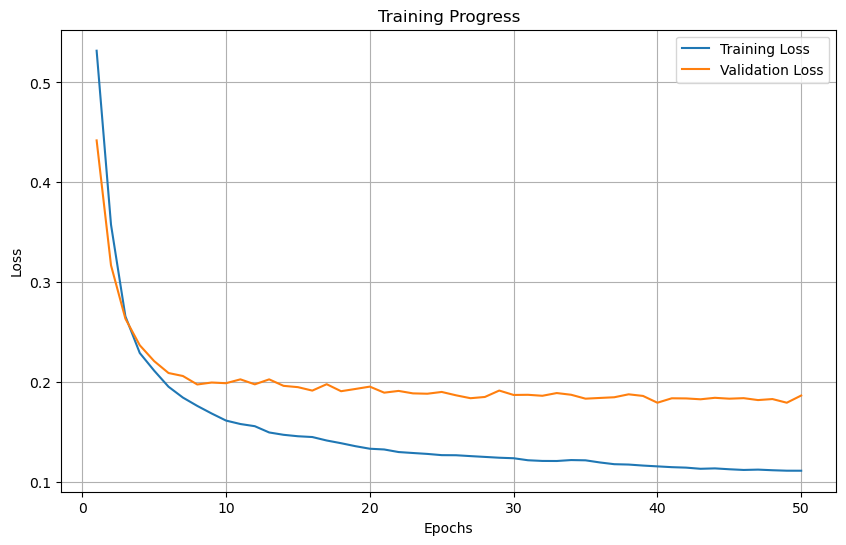

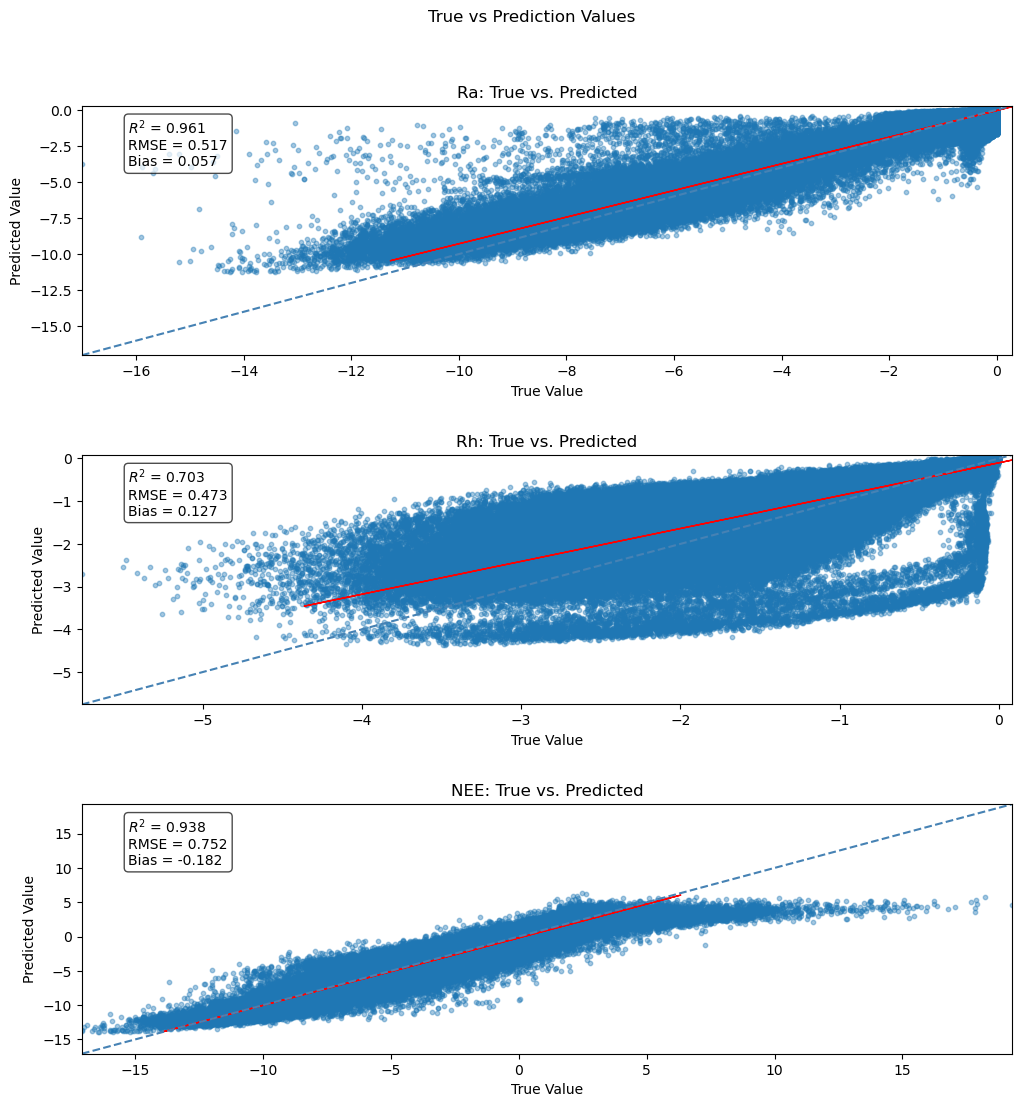

In [61]:
# Testing the model
myKGML1.test()

# visualization
myKGML1.plot_training_curves()

output_feature_name = ['Ra','Rh','NEE']
myKGML1.vis_scatter_prediction_result(y_scaler, output_feature_name)

### Step 5: loss function customization

In this step, we will explore anther compiler of PyKGML, which is used for customizing loss functions. The loss function is a core component of any machine learning models. It measures how far the model’s predictions are from the true values, guiding the optimization process. During training, the model adjusts its parameters to minimize this loss, effectively “learning” from its mistakes. Choosing a loss function depends on the task and objectives. For example, continuous error measures, e.g., mean standard errors (MSE), are usually selected in regression problems, and cross-entropy loss is commonly used for classification. For specialized research question, cutomization a loss function that reflect domain-specific goals can enhance the model performance or interpretability.

1. **Mass balance as a physical constraint**        
    Here we'd like to introduce some scientific background associated with the predicted variables to justify the need of creating a loss function. 

    In step 3, we pretrained a model to predict daily Ra, Rh, and NEE. From previous steps, we know that Ra, Rh and NEE are individual predictions of the model. Although Ra and Rh serve as intermediate inputs for predicting NEE in step 4, there is no certain explicit relationship. However, in the real world, certain physical laws exist among the three response variables and thus predictions without constraints may violate those physical laws and led to significant biases. 
    For Ra, Rh, and NEE, the following relationships exist:  
    <pre>  
            1. Ecosystem respiration: Reco = Ra + Rh  
                
            2. Mass balance: NEE = GPP - Reco  (GPP is an feature in the model inputs)
    </pre>

    In addition to individually predicting Ra, Rh, and NEE, we want to constrain the predicted values so that the mass balance is possibly maintained. Therefore, we customize a loss function that contain the residual of equation 2 to reflect the mass balance constraint:
    <pre>   
            loss1 = mean[MSE(Ra, pred_Ra) + MSE(Rh, pred_Rh) + MSE(NEE, pred_NEE)]  
            
            loss2 = mean[abs(GPP - pred_Reco - pred_NEE)] - tol_MB * abs(pred_Reco)  
                
            loss = loss1 + loss2    
    </pre>   
    
    Loss1 is the mean sqaure errors of predictions and true values. Loss2 is residual of the mass balance substracted by a scaler of pred_Reco, added as a panelty in the total loss. Loss 2 allows the residual of the mass balance to be larger when pred_Reco is larger.


2. **Configuration**
    The configuration consists of three dictionaries to be filled:
    - `parameters`: parameters that are used in the calculation of the loss function. There are 3 latent parameters `batch_x`, `y_pred`, and `y_true` that can be used but don't need to be added.

    - `variables`: variables that are used in the calculation of the loss function. Those variables should be retrived from latent parameters, or calculated by declared and latent parameters. To specify a variable, the index of the variable in its source tensor (`batch_x`, `y_pred`, or `y_true`) can be added as a parameter in `parameters`. The format of variables is string.

    - `loss_formula`: the formula of the proposed loss function. The loss used for backpropogation should be stored under the key `loss`. Any intermediate computations should use different key names.
    
    Here is a example configuration of a simple MSE loss function:

    ```python
        lossfn_config = {
            # parameters that are used in the calculation of the loss function
            'parameters': {
                'par1_idx': 0},
            # Explicitly define each term that will be used in the loss function.
            # Because X and Y had been normalized, terms in the mass balance need to be reversed.
            'variables': {
                'par1_pred': 'y_pred[:, :, par1_idx]',
                'par1_true': 'y_true[:, :, par1_idx]',
                },
                # Define the loss function.
            'loss_formula': {
                'loss': 'mean((par1_pred - par1_true)**2)'
                }
            }
    ```

In [ ]:
# Import the help compiler
LossFunctionCompiler = kgml_lib.LossFunctionCompiler

# GPP is the No. 9 feature in the inputs X
GPP_scaler = x_scaler[8]
# configure a script for building a loss function
lossfn_config = {
    # Parameters that are used in the calculation of the loss function
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 2,
        'tol_MB': 0.01,
        'aaa_scaler': x_scaler,
        'ccc_scaler':y_scaler},
    # Explicitly define each term that will be used in the loss function.
    # Because X and Y had been normalized, terms in the mass balance need to be reversed.
    'variables': {
        'Ra_pred': 'y_pred[:, :, Ra_idx]',
        'Rh_pred': 'y_pred[:, :, Rh_idx]',
        'NEE_pred': 'y_pred[:, :, NEE_idx]',
        'GPP_reverse': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler[GPP_idx])',
        'Ra_pred_reverse': 'Z_norm_reverse(y_pred[:, :, Ra_idx], ccc_scaler[Ra_idx])',
        'Rh_pred_reverse': 'Z_norm_reverse(y_pred[:, :, Rh_idx], ccc_scaler[Rh_idx])',
        'NEE_pred_reverse': 'Z_norm_reverse(y_pred[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        'Ra_true': 'y_true[:, :, Ra_idx]',
        'Rh_true': 'y_true[:, :, Rh_idx]',
        'NEE_true': 'y_true[:, :, NEE_idx]',
        },
        # Define the loss function.
    'loss_formula': {
        'Reco_pred_reverse': 'Ra_pred_reverse + Rh_pred_reverse',
        'loss1': 'mean((Ra_pred - Ra_true)**2 + (Rh_pred - Rh_true)**2 + (NEE_pred - NEE_true)**2)',
        'loss2': 'mean(relu(abs(GPP_reverse + Reco_pred_reverse + NEE_pred_reverse)  - tol_MB * abs(Reco_pred_reverse)))',
        'loss': 'loss1 + loss2',}
    }

In [63]:
# Create the compiler
lossfn_compiler = LossFunctionCompiler(lossfn_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(lossfn_compiler.class_code)

# Create the loss class
customLoss = lossfn_compiler.generate_class()
loss_fn = customLoss()

Generated CarbonFluxLoss:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_idx=0, Rh_idx=1, NEE_idx=2, tol_MB=0.01, aaa_scaler=[[15.053108964474006, 7.326538061301864], [17.193964650486368, 12.213991763373388], [9.976644474999615, 3.920628242251278], [1.4331655554728224, 0.8649237300133734], [0.42117767163499437, 0.2976678281986924], [373.3158668814395, 144.32230851758112], [2.8037624222923756, 7.2096132460220135], [3.000774068698597, 1.9999998502044234], [2.8892129010294383, 5.757924175519595], [2009.500244140625, 5.1881279945373535], [1.3850725548995193, 0.10334471059856785], [165.73811764894734, 179.75278592057546], [591.1589363146128, 161.2505438232744], [0.2988145731775208, 0.04200548586636309], [0.16535801808608863, 0.04892610339609015], [30.943542166741274, 38.18836355218684], [17.082202355828215, 19.632706474926852], [6.237856846289411, 0.4814664318210326], [20.170418101874997, 8.91454300038102]], ccc_scaler=[[-1.35840237

In [64]:
# We will create a model the same as the model in step 3 to use the loss function
myKGML2 = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

# Load the model weights from the training of the previous model
checkpoint_path = output_path + 'pretrained_GRU.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)
myKGML2.load_pretrained(pretrained_model_path=checkpoint_path)

# Create DataLoaders
myKGML2.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
myKGML2.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

GRUSeq2SeqWithAttention(
  (gru): GRU(19, 128, num_layers=3, batch_first=True)
  (attention): Attention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model's state_dict:
gru.weight_ih_l0 	 torch.Size([384, 19])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
gru.weight_ih_l1 	 torch.Size([384, 128])
gru.weight_hh_l1 	 torch.Size([384, 128])
gru.bias_ih_l1 	 torch.Size([384])
gru.bias_hh_l1 	 torch.Size([384])
gru.weight_ih_l2 	 torch.Size([384, 128])
gru.weight_hh_l2 	 torch.Size([384, 128])
gru.bias_ih_l2 	 torch.Size([384])
gru.bias_hh_l2 	 torch.Size([384])
attention.query.weight 	 torch.Size([128, 128])
attention.query.bias 	 torch.Size([128])
attention.key.weight 

The model parameters and hyperparameters for training are the same as in the step 3, except that the loss function should be the customzed "loss_fn".

In [65]:
batch_size = 64
learning_rate = 0.001
step_size = 10
max_epoch = 25
gamma = 0.6

new_checkpoint_path = output_path + 'customLoss_GRU.pth'
# Train the model with the customzed loss function
myKGML2.train_model(loss_func=loss_fn, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=new_checkpoint_path)


Epoch 1/25 | LR: 0.001000, Train Loss: 0.8980, Test Loss: 0.6538
Epoch 2/25 | LR: 0.001000, Train Loss: 0.5708, Test Loss: 0.6382
Epoch 3/25 | LR: 0.001000, Train Loss: 0.5013, Test Loss: 0.5020
Epoch 4/25 | LR: 0.001000, Train Loss: 0.4060, Test Loss: 0.4910
Epoch 5/25 | LR: 0.001000, Train Loss: 0.3955, Test Loss: 0.4655
Epoch 6/25 | LR: 0.001000, Train Loss: 0.3578, Test Loss: 0.4602
Epoch 7/25 | LR: 0.001000, Train Loss: 0.3451, Test Loss: 0.4222
Epoch 8/25 | LR: 0.001000, Train Loss: 0.3294, Test Loss: 0.4410
Epoch 9/25 | LR: 0.001000, Train Loss: 0.3387, Test Loss: 0.4909
Epoch 10/25 | LR: 0.000600, Train Loss: 0.3464, Test Loss: 0.4485
Epoch 11/25 | LR: 0.000600, Train Loss: 0.3137, Test Loss: 0.4224
Epoch 12/25 | LR: 0.000600, Train Loss: 0.3058, Test Loss: 0.4260
Epoch 13/25 | LR: 0.000600, Train Loss: 0.3038, Test Loss: 0.4460
Epoch 14/25 | LR: 0.000600, Train Loss: 0.3012, Test Loss: 0.4301
Epoch 15/25 | LR: 0.000600, Train Loss: 0.2992, Test Loss: 0.4257
Epoch 16/25 | LR: 0

Test Loss: 0.3988


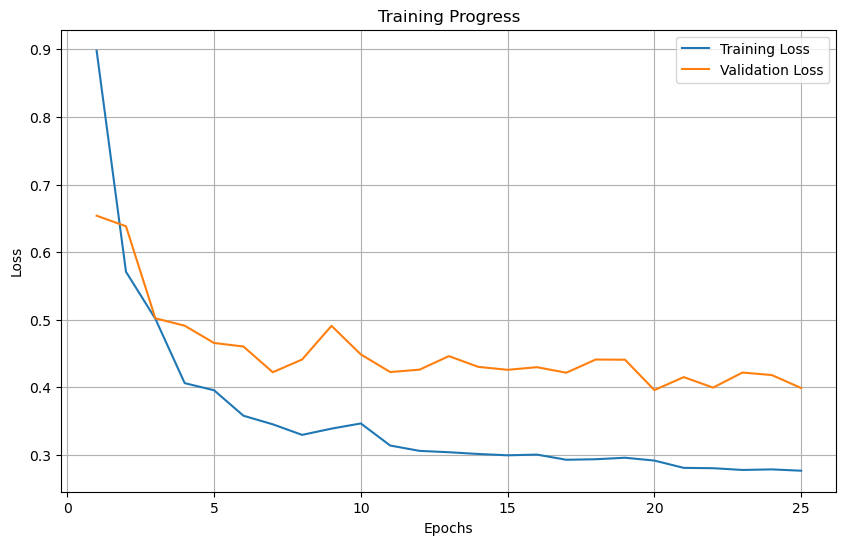

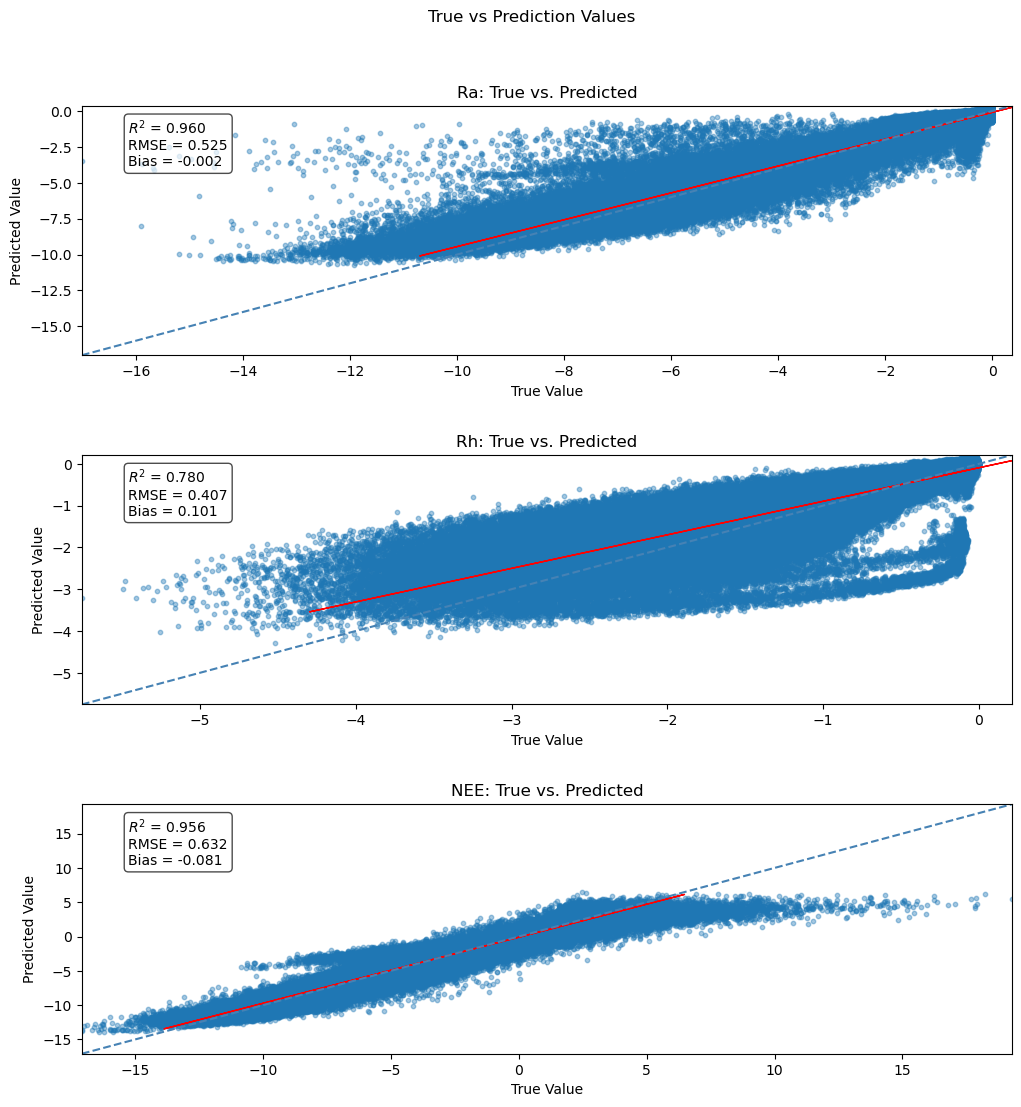

In [66]:
# Test the model
myKGML2.test()

# Visualize the learning curves
myKGML2.plot_training_curves()

# Visualize a scatter plot
output_feature_name = ['Ra','Rh','NEE']
myKGML2.vis_scatter_prediction_result(y_scaler, output_feature_name)

### Step 6: fine tune a pretrained model

Fine-tuning a model using real observations can adjust the model to be more adaptive to the observed conditions. To do so, weights of the pretrained model will be used as its the initial weights during the fine-tuning. In this step, we will learn how to fine-tune a pretrained model using field observations. 

1. **Load pretrained parameters**

    In PyKGML, we use the `load_pretrained()` function to load parameters from a file.
    ```python
    checkpoint_path = output_path + 'pretrained_GRU.pth'
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    KGML_ft = GRUSeq2SeqWithAttention(ft_input_dim, hidden_dim, num_layers, ft_output_dim, dropout)
    # reload model weights
    KGML_ft.load_pretrained(pretrained_model_path=checkpoint_path)
    ```
<br>

2. **Loss function configuration**  

    You may have found previously in the dataset description that the example fine-tuning dataset (co2_finetune_data) has different output features than the pretraining dataset (co2_pretrain_data). In the fine-tuning dataset, there are only two output variables: Reco and NEE, because Ra and Rh do not exist in the real observations. We need to modify the loss function as the follows so that Reco can be compared with the sum of predicted Ra and predicted Rh. 
    <pre>   
                loss = mean[MSE(Reco, pred_Ra + pred_Rh) + MSE(NEE, pred_NEE)]
    </pre>   
    
    Other important notes about the fine-tuning dataset:  
    - Reco and NEE (in Y_train and Y_test) are not standardized, and should be compared with reversed values of the corresponding model prediction. 

    - Reco values are positive, not negative as in the synthetic data.



In [67]:
# Assign training and testing data. 
X_train_ft, X_test_ft, Y_train_ft, Y_test_ft = finetune_data['X_train'], finetune_data['X_test'], finetune_data['Y_train'], finetune_data['Y_test']
x_scaler_ft = finetune_data['x_scaler']
input_features_ft = finetune_data['input_features']
output_features_ft = finetune_data['output_features']

print(X_train_ft.shape, Y_train_ft.shape, X_test_ft.shape, Y_test_ft.shape)
print(input_features_ft,output_features_ft)

torch.Size([1, 37230, 19]) torch.Size([1, 37230, 2]) torch.Size([1, 8030, 19]) torch.Size([1, 8030, 2])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC'] ['NEE', 'RECO']


In [ ]:
# configure a script to customize a loss function for fune-tuning

ft_lossfn_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_pred_idx': 0,
        'Rh_pred_idx': 1,
        'NEE_pred_idx': 2,
        'NEE_true_idx': 0,
        'Reco_true_idx': 1,
        'aaa_scaler': x_scaler,
        'bbb_scaler': y_scaler},
    # revise this part to remove scaler and z_norm_reverse. 1. scaling methods (pre-define) 2. scaler
    'variables': {
        'Ra_pred': 'y_pred[:, :, Ra_pred_idx]',
        'Rh_pred': 'y_pred[:, :, Rh_pred_idx]',
        'NEE_pred': 'y_pred[:, :, NEE_pred_idx]',
        'NEE_true': 'y_true[:, :, NEE_true_idx]',
        'Reco_true': 'y_true[:, :, Reco_true_idx]',
        'GPP_reverse': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler[GPP_idx])',
        'Ra_pred_reverse': '-Z_norm_reverse(y_pred[:, :, Ra_pred_idx], bbb_scaler[Ra_pred_idx])',
        'Rh_pred_reverse': '-Z_norm_reverse(y_pred[:, :, Rh_pred_idx], bbb_scaler[Rh_pred_idx])',
        'NEE_pred_reverse': 'Z_norm_reverse(y_pred[:, :, NEE_pred_idx], bbb_scaler[NEE_pred_idx])',
        },
    
    'loss_formula': {
        'Reco_pred_reverse': 'Ra_pred_reverse + Rh_pred_reverse',
        'loss': 'mean((NEE_pred_reverse - NEE_true)**2 + (Reco_pred_reverse - Reco_true)**2)',
        }
    }

In [69]:
# Create the compiler
ft_lossfn_compiler = LossFunctionCompiler(ft_lossfn_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(ft_lossfn_compiler.class_code)

# Create the loss class
ft_customLoss = ft_lossfn_compiler.generate_class()
ft_loss_fn = ft_customLoss()

Generated CarbonFluxLoss:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_pred_idx=0, Rh_pred_idx=1, NEE_pred_idx=2, NEE_true_idx=0, Reco_true_idx=1, aaa_scaler=[[15.053108964474006, 7.326538061301864], [17.193964650486368, 12.213991763373388], [9.976644474999615, 3.920628242251278], [1.4331655554728224, 0.8649237300133734], [0.42117767163499437, 0.2976678281986924], [373.3158668814395, 144.32230851758112], [2.8037624222923756, 7.2096132460220135], [3.000774068698597, 1.9999998502044234], [2.8892129010294383, 5.757924175519595], [2009.500244140625, 5.1881279945373535], [1.3850725548995193, 0.10334471059856785], [165.73811764894734, 179.75278592057546], [591.1589363146128, 161.2505438232744], [0.2988145731775208, 0.04200548586636309], [0.16535801808608863, 0.04892610339609015], [30.943542166741274, 38.18836355218684], [17.082202355828215, 19.632706474926852], [6.237856846289411, 0.4814664318210326], [20.170418101874997, 8.9145430

In [70]:
# Define hyperparameters
ft_input_dim = len(input_features)
hidden_dim = 128
num_layers = 3
ft_output_dim = len(output_features)
dropout=0.2

# Locate the weight file saved during the pretraining 
checkpoint_path = output_path + 'pretrained_GRU.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)

# Define the fine-tuning model parameters, which be the same as the pretrained model
# KGML_ft = KGML(input_dim, hidden_dim, num_layers, ft_output_dim, dropout)
KGML_ft = GRUSeq2SeqWithAttention(ft_input_dim, hidden_dim, num_layers, ft_output_dim, dropout)
# reload model weights
KGML_ft.load_pretrained(pretrained_model_path=checkpoint_path)

GRUSeq2SeqWithAttention(
  (gru): GRU(19, 128, num_layers=3, batch_first=True)
  (attention): Attention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model's state_dict:
gru.weight_ih_l0 	 torch.Size([384, 19])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
gru.weight_ih_l1 	 torch.Size([384, 128])
gru.weight_hh_l1 	 torch.Size([384, 128])
gru.bias_ih_l1 	 torch.Size([384])
gru.bias_hh_l1 	 torch.Size([384])
gru.weight_ih_l2 	 torch.Size([384, 128])
gru.weight_hh_l2 	 torch.Size([384, 128])
gru.bias_ih_l2 	 torch.Size([384])
gru.bias_hh_l2 	 torch.Size([384])
attention.query.weight 	 torch.Size([128, 128])
attention.query.bias 	 torch.Size([128])
attention.key.weight 

In [71]:
# Use 365 consecutive days as a sample
sequence_length = 365

# Create Dataset objects for training and testing.
train_dataset_ft = SequenceDataset(X_train_ft, Y_train_ft, sequence_length)
test_dataset_ft = SequenceDataset(X_test_ft, Y_test_ft, sequence_length)

# Create DataLoaders.
batch_size = 64
KGML_ft.train_loader = DataLoader(train_dataset_ft, batch_size=batch_size, shuffle=True)
KGML_ft.test_loader  = DataLoader(test_dataset_ft, batch_size=1, shuffle=False)

In [72]:
learning_rate = 0.001
step_size = 20
max_epoch = 100
gamma = 0.8

ft_checkpoint_path = output_path + 'finetune_GRU.pth'
# Train the model
KGML_ft.train_model(loss_func=ft_loss_fn, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=ft_checkpoint_path)

Epoch 1/100 | LR: 0.001000, Train Loss: 3.0482, Test Loss: 3.1385
Epoch 2/100 | LR: 0.001000, Train Loss: 2.9266, Test Loss: 2.5791
Epoch 3/100 | LR: 0.001000, Train Loss: 2.4879, Test Loss: 2.4461
Epoch 4/100 | LR: 0.001000, Train Loss: 2.3630, Test Loss: 2.1200
Epoch 5/100 | LR: 0.001000, Train Loss: 1.9932, Test Loss: 2.1316
Epoch 6/100 | LR: 0.001000, Train Loss: 1.8893, Test Loss: 2.0601
Epoch 7/100 | LR: 0.001000, Train Loss: 1.8794, Test Loss: 1.8876
Epoch 8/100 | LR: 0.001000, Train Loss: 1.7581, Test Loss: 1.8786
Epoch 9/100 | LR: 0.001000, Train Loss: 1.8364, Test Loss: 1.8195
Epoch 10/100 | LR: 0.001000, Train Loss: 1.6812, Test Loss: 1.8079
Epoch 11/100 | LR: 0.001000, Train Loss: 1.6482, Test Loss: 1.7777
Epoch 12/100 | LR: 0.001000, Train Loss: 1.6574, Test Loss: 1.7793
Epoch 13/100 | LR: 0.001000, Train Loss: 1.6677, Test Loss: 1.7535
Epoch 14/100 | LR: 0.001000, Train Loss: 1.5674, Test Loss: 1.7534
Epoch 15/100 | LR: 0.001000, Train Loss: 1.6855, Test Loss: 1.7646
Epoc

/Users/yufengyang/Documents/GitHub/PyKGML_development/time_series_models.py:449: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(checkpoint_pat

**Visualization**   

Due to the mismatch in the outputs of the pretrained model ([Ra, Rh, NEE]) and the fine-tune dataset ([NEE, Reco]), we need to reconstruct the prediction and true value for some functions that use both, such as get_R2_score() and Vis_scatter_prediction_result().

Test Loss: 1.2083


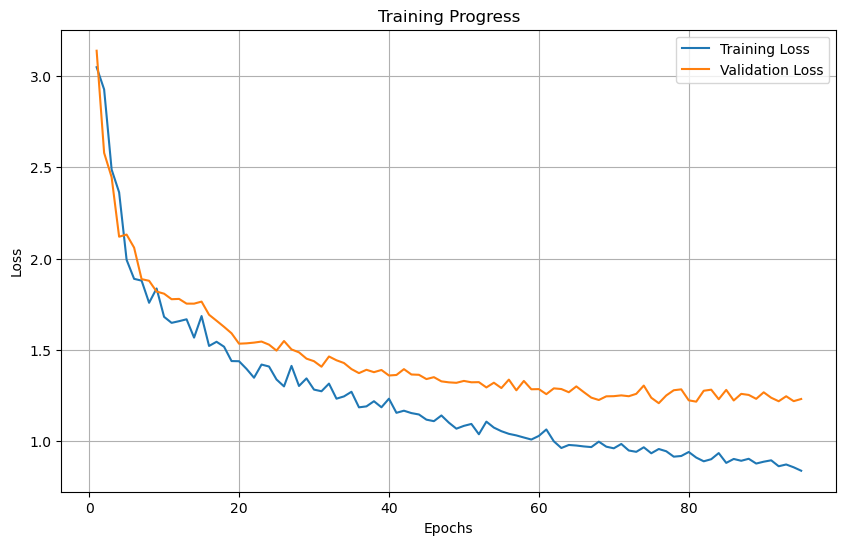

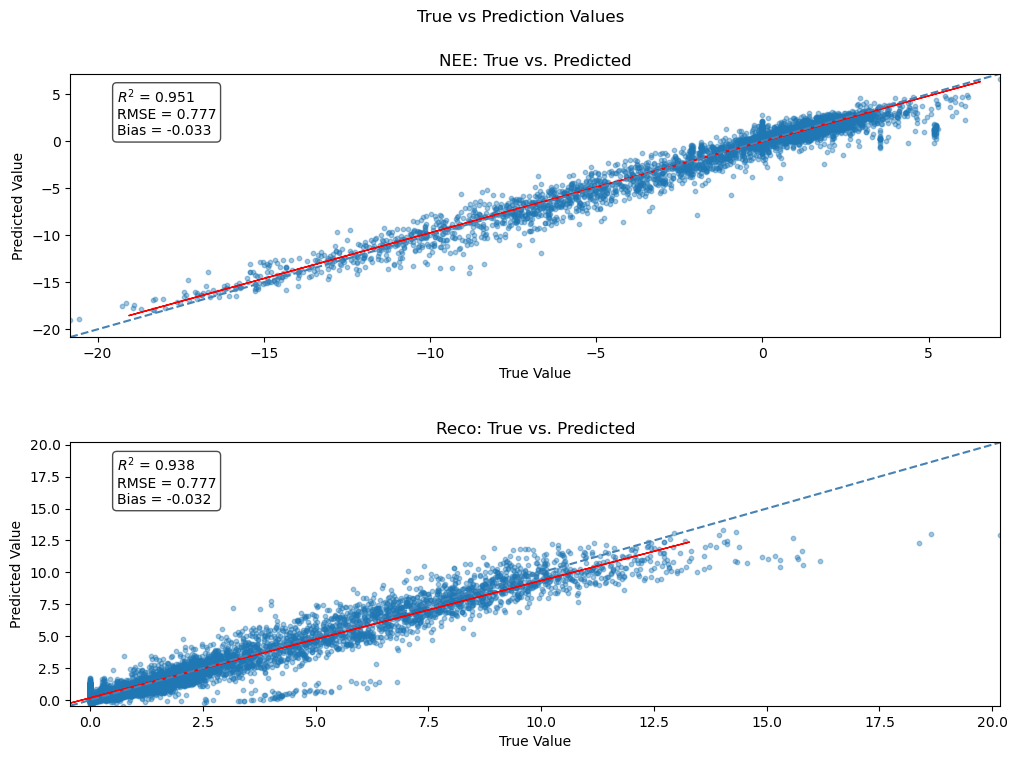

In [73]:
# Import functions for calculating R2 and visualizing results
from kgml_lib import get_R2_score, vis_scatter_prediction_result, Z_norm_reverse
KGML_ft.test()
# Visualize the learning curves
KGML_ft.plot_training_curves()

# Construct a prediction that contains [NEE, Reco] from the direct model outputs of [Ra, Rh, NEE]
ft_Ra_pred = Z_norm_reverse(KGML_ft.all_predictions[:,:,0], y_scaler[0])
ft_Rh_pred = Z_norm_reverse(KGML_ft.all_predictions[:,:,1], y_scaler[1])
ft_NEE_pred = Z_norm_reverse(KGML_ft.all_predictions[:,:,2], y_scaler[2])
ft_predictions = torch.stack([ft_NEE_pred, -(ft_Ra_pred + ft_Rh_pred)], dim=2)
ft_targets = KGML_ft.all_targets

# The predictions have been reversed using the y_scaler.
y_scaler_ft = None
output_feature_name = ['NEE', 'Reco']
vis_scatter_prediction_result(target=ft_targets, prediction=ft_predictions, y_scaler=y_scaler_ft, features=output_feature_name)


### This is the end of the tutorial. 

In conclusion, we explored the following things with PyKGML:

1. Pretrained a baseline GRU-based model on synthetic data.

2. Designed a hierarchical structure incorporating knowledge of causal relationships. This design demonstrated potential to outperform the baseline, as shown in the original paper ([Liu 2024](https://www.nature.com/articles/s41467-023-43860-5)).  

3. Customized a loss function to be used for model training.

4. Fine-tuned a pretrained model leveraging the loss function design to constrain the model prediction with related variables from the observation.  